# SEIR


## Model description

The SEIR Model is an Compartmental model, these try to predict things such as
how a disease spreads, or the total number infected, or the duration of an
epidemic, and to estimate various epidemiological parameters such as the
reproductive number.
The dynamics are described as follows:

$$
  \left\{ \begin{array}{lcl}
  \frac{dS}{dt} & = & \beta I S \\
  \frac{dE}{dt} & = & \beta I S - \alpha E \\
  \frac{dI}{dt} & = & -\gamma I - \alpha E \\
  \frac{dR}{dt} & = & \gamma I
  \end{array} \right.
$$

where ``S`` is the stock of susceptible population, ``E`` is the stock of
exposed population``I`` is the stock of infected, ``R`` is the stock of
removed population (either by death or recovery), with ``S + E + I + R = N``

In [1]:
using ReachabilityAnalysis, Plots

@taylorize function seir2!(du,u,p,t)
  S, E, I, R, α, β, γ = u

  βIS = β * (I * S)
  αE = α*E
  γI = γ*I

  du[1] = -βIS      # dS
  du[2] = βIS - αE  # dE
  du[3] = -γI + αE  # dI
  du[4] = γI        # dR

  #uncertain parameters
  local zerou = zero(u[1])
  du[5] = zerou
  du[6] = zerou
  du[7] = zerou
end

E₀ = 1e-4
u₀ = [1-E₀, E₀, 0, 0]
param_error = 0.01
α = 0.2 ± param_error
β = 1.0 ± 0.0
γ = 0.5 ± param_error
p = [α, β, γ]
X0 = IntervalBox(vcat(u₀, p));
prob = @ivp(x' = seir2!(x), dim=7, x(0) ∈ X0);

## Reachability settings

The initial values used were ``E₀ = 1e-4, u₀ = [1-E₀, E₀, 0, 0]``,
``α = 0.2 ± 0.01, β = 1.0 ± 0.0, γ = 0.5 ± 0.01`` and ``p = [α, β, γ]``, for a
time span of 200.
The algorithm used was `TMJets` with ``n_T=7`` and ``n_Q=1``

## Results

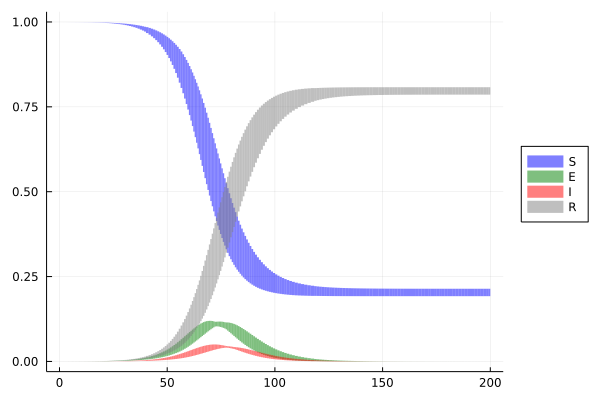

In [2]:
sol = solve(prob, tspan=(0.0, 200.0), alg=TMJets21a(orderT=7, orderQ=1));
solz = overapproximate(sol, Zonotope);

LazySets.set_ztol(Float64, 1e-13)
fig = plot(legend=:outerright)
plot!(fig, solz, vars=(0, 1), color=:blue, lw=0.0, lab="S")
plot!(fig, solz, vars=(0, 2), color=:green, lw=0.0, lab="E")
plot!(fig, solz, vars=(0, 3), color=:red, lw=0.0, lab="I")
plot!(solz, vars=(0, 4), color=:grey, lw=0.0, lab="R")
fig